In [40]:
import pandas as pd
from dask import dataframe as dask_dataframe
import matplotlib.pyplot as plt

from matplotlib import rcParams
import matplotlib as mpl
mpl.rcParams['text.usetex'] = True
mpl.rcParams['axes.linewidth'] = 2
rcParams['savefig.dpi'] = 850
rcParams['font.size'] = 20
import numpy as np
%config InlineBackend.figure_format = "retina"
from tqdm import tqdm
from astropy.io import ascii
import os
import sys
import astropy.stats as astro_stats

%matplotlib inline

# relative path to dipper code
sys.path.append('../dipper/')


In [3]:
# dipper detection pipeline
%load_ext autoreload
%autoreload 2

import dipper as dipper 
import tools as tools
from evaluate import evaluate_updated
from evaluate import half_eval

## Mock signals

In [4]:
## Parametric models: Generalized Gaussian, and Skew-Normal ##
from math import gamma
from scipy.special import erf
import astropy.stats as astro_stats

def skew_norm(x, mu, sigma, alpha, ofs, amp):
    """
    Skew-normal distribution modified with an offset term and amplitude to fit the light curves.
    
    Parameters:
    -----------
    x (array-like): Input time values.
    mu (float): Mean of the distribution.
    sigma (float): Standard deviation of the distribution.
    alpha (float): Shape parameter controlling the skewness of the distribution.
    ofs (float): Offset term.

    Returns:
    --------
    y (array-like): Output magnitude values.
    """
    gaus = 1/np.sqrt(2*np.pi) * np.exp(-(x-mu)**2/sigma**2)
    FI = 0.5 * (1 + erf(alpha*(x-mu)/np.sqrt(2)))
    return ofs + amp*2*gaus*FI

def ggd(x, mu, alpha, beta, ofs, amp):
    """
    Generalized Gaussian Distribution modified with an offset term and amplitude to fit the light curves.
    
    Parameters:
    -----------
    x (array-like): Input time values.
    mu (float): Mean of the distribution.
    alpha (float): Scale parameter (i.e SIGMA).
    beta (float): Shape parameter.
    ofs (float): Offset term.
    amp (float): Amplitude term

    Returns:
    --------
    y (array-like): Output magnitude values.
    """

    term_1 = beta/(2*alpha*gamma(1/beta))
    abs_term = ((abs(x-mu))/alpha)**beta
    mm = amp * term_1 * np.exp(-abs_term)
    return mm + ofs

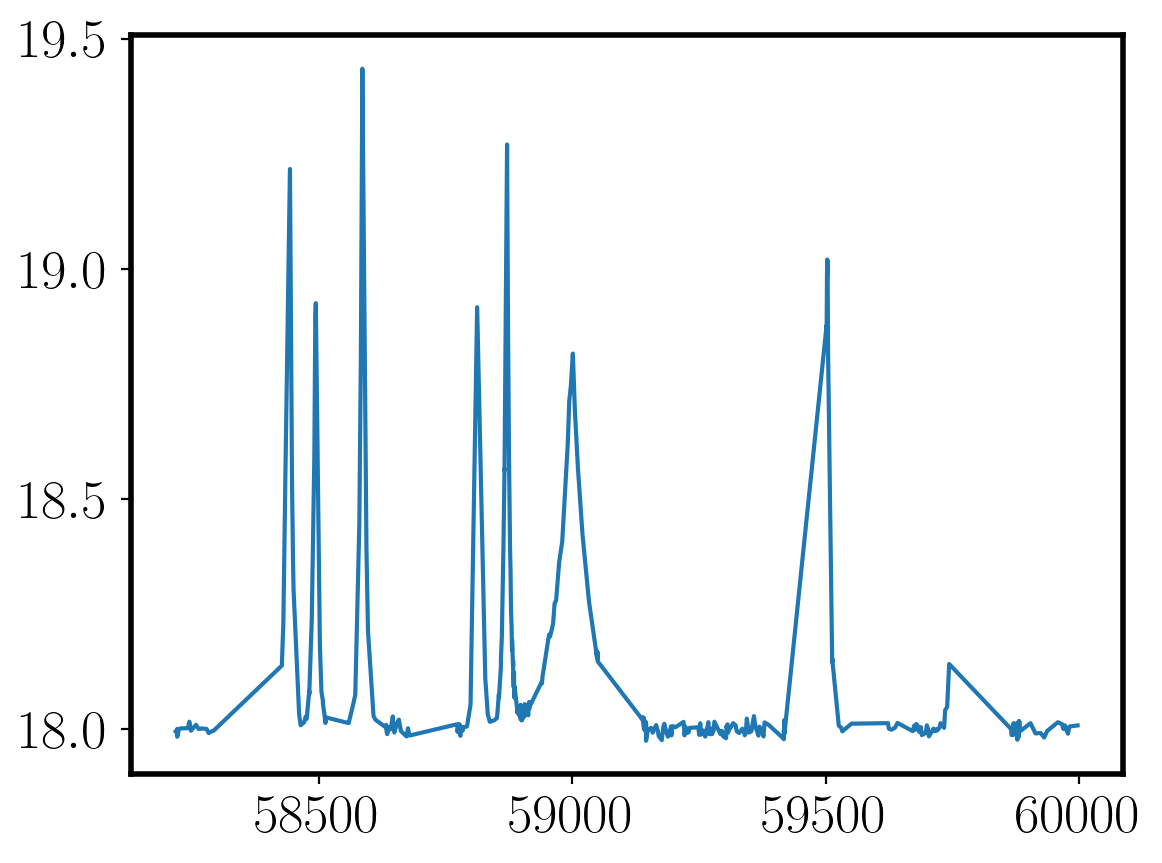

In [118]:
# times from a random ZTF field
times = ascii.read("https://ztf.snad.space/dr17/csv/574211400034900")['mjd'].value

# Simulated dipper signal
model = ggd(times, 59_000, 30, 1, 18, 50)

for j in range(10):
    model += ggd(times, 59_000+np.random.randint(-1250, 950), 5, 1, 0, np.random.randint(5, 25))

model += np.random.normal(0, 0.01, len(times)) # add noise
errs = abs(np.random.normal(0, 0.01, len(times))) # add fake errors

flt = ['r' for _ in range(len(times))]
fltg = ['g' for _ in range(len(times))]
flg = np.zeros(len(times))

plt.plot(times, model)

## Light Curve Eval

In [119]:
obs_time = np.concatenate([times, times])
obs_mag = np.concatenate([model, model])
obs_magerr = np.concatenate([errs, errs])
obs_filter = np.concatenate([flt, fltg])
obs_flags = np.concatenate([flg, flg])

going in here!
makes it here!
0.07814411573055025
0.04018269814925034
0.03410658938297942
0.07281689510654396
0.015425873960685864
0.004611420048464742


2.0414733980614534

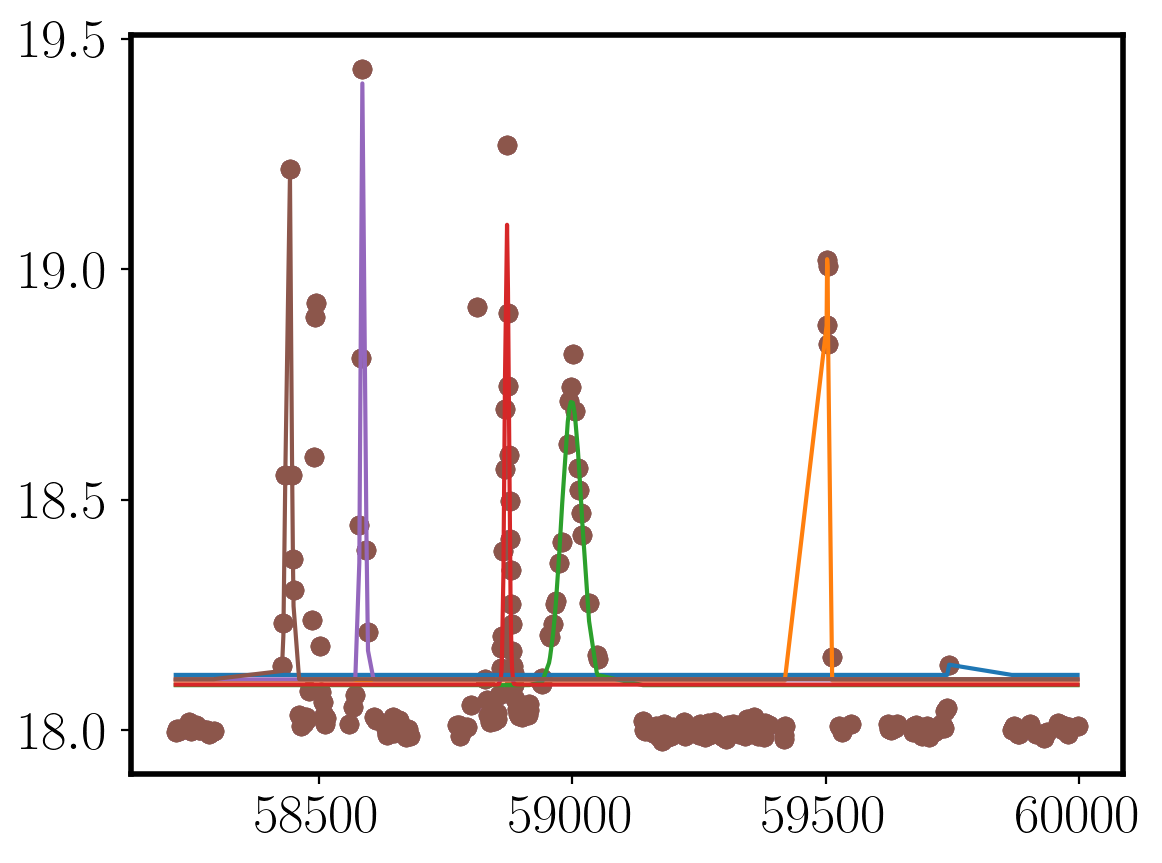

In [120]:
np.log(evaluate_updated(obs_time, obs_mag, obs_magerr, obs_flags, obs_filter)['lc_score'])

In [93]:
# TODO: Fix and try to understand...
evaluate_updated(obs_time, obs_mag, obs_magerr, obs_flags, obs_filter)

Nphot                 2.750000e+02
biweight_scale        1.398591e-02
frac_above_2_sigma    4.727273e-02
Ndips                 2.000000e+00
rate                  1.124825e-03
chi2dof               1.063502e+00
skew                  5.235873e+00
kurtosis              3.155038e+01
mad                   8.850456e-03
stetson_i             2.565394e+06
stetson_j             4.609373e+03
stetson_k             1.257196e-01
invNeumann            3.429634e-01
best_dip_power                 NaN
best_dip_time_loc              NaN
best_dip_start                 NaN
best_dip_end                   NaN
best_dip_dt                    NaN
best_dip_ndet                  NaN
lc_score                       NaN
dtype: float64

In [80]:
obs_r = times, model, errs, flt, flg
obs_g = times, model, errs, fltg, flg
